In [98]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, KBinsDiscretizer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, cross_validate
from sklearn.metrics import accuracy_score, balanced_accuracy_score
import pickle
import shap
from collections import defaultdict

## Data preprocessing

In [2]:
from enoe import load_enoe

enoe = load_enoe()

y = enoe['informal']
X = enoe.drop(columns='informal')

In [3]:
# Base rate
y.value_counts().max()/len(y)

# We must aim for an accuracy significally better than 63%

0.6241807519834426

## Table of candidate models

| Model family|Education preprocessing |Parameter 1   | Parameter 2|
|-------------|------------------------|--------------------------------------------------------------------|-----------------------------|
|LR           |                  scaled| $C \in \{10^x | x = -4 + \frac{8}{9}i,  i \in \{0, 1,\ldots, 9\}\}$|                             |
|LR           |             discretized| $C \in \{10^x | x = -4 + \frac{8}{9}i,  i \in \{0, 1,\ldots, 9\}\}$| $k \in \{5, 6, \ldots, 10\}$|
|LR           |       census categories| $C \in \{10^x | x = -4 + \frac{8}{9}i,  i \in \{0, 1,\ldots, 9\}\}$|                             |
|RF           |                     raw| max_features $\in \{1,\ldots, 6\}$                                 | max_leaf_modes $\in \{5, 7, 10, 25,  50,  65,  85, 100, 250, 500\}$ | 
|RF           |       census categories| max_features $\in \{1,\ldots, 6\}$                                 | max_leaf_modes $\in \{5, 7, 10, 25,  50,  65,  85, 100, 250, 500\}$ | 
|GB           |                     raw| learning_rate $\in \{10^x | x = -1 + \frac{2}{9}i,  i \in \{0, 1,\ldots, 9\}\}$                                | max_leaf_modes $\in \{5, 7, 10, 25,  50,  65,  85, 100, 250, 500\}$ | 
|GB           |       census categories| learning_rate $\in \{10^x | x = -1 + \frac{2}{9}i,  i \in \{0, 1,\ldots, 9\}\}$                                | max_leaf_modes $\in \{5, 7, 10, 25,  50,  65,  85, 100, 250, 500\}$ | 
|SVC          |                  scaled| $C \in \{10^x | x = -4 + \frac{8}{9}i,  i \in \{0, 1,\ldots, 9\}\}$| $\gamma \in \{10^x | x = -4 + \frac{8}{9}i,  i \in \{0, 1,\ldots, 9\}\}$|
|SVC          |       census categories| $C \in \{10^x | x = -4 + \frac{8}{9}i,  i \in \{0, 1,\ldots, 9\}\}$| $\gamma \in \{10^x | x = -4 + \frac{8}{9}i,  i \in \{0, 1,\ldots, 9\}\}$|
|KNN          |       census categories| $K \in \{1, \ldots, 10 \}$    |

## Load grid search results

In [4]:
cv_results = pd.read_pickle('repeated_cv_results.pkl')

cv_results = cv_results.rename(columns={c: c.split('param_')[-1] for c in cv_results.columns if c.startswith('param_')})

print(f'Total models compared: {int(cv_results.shape[0]/10)}')

#best_models = pd.read_csv('repeated_best_models.csv', index_col=0, header=[0,1]).sort_values(('balanced_accuracy', 'mean'), ascending=False)
#best_models

Total models compared: 610


## Extracting best models for each algorithm for each outer fold

In [61]:
top_models = cv_results.loc[cv_results.groupby(['fold', 'model']).mean_test_score.idxmax()].set_index(['fold', 'model']).sort_index()

In [64]:
%%time
from models_grids import models_LR, models_RF, models_GB, models_SVC, models_KNN

models = models_LR | models_RF | models_GB | models_SVC | models_KNN

cv_outer = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_outer_idxs = list(cv_outer.split(X, y))

# Retrain models on same outer folds

scores = defaultdict(list)

for (fold, model_key), row in top_models.iterrows():
    train_index, test_index = cv_outer_idxs[fold]
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_test, y_test = X.iloc[test_index], y.iloc[test_index]

    params = row.params
    model = models[model_key]['model'].set_params(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = balanced_accuracy_score(y_test, y_pred)
    scores[model_key].append((fold, score))
#pd.Series({'mean_balanced_accuracy': np.mean(scores), 'std_balanced_accuracy': np.std(scores), 'mean_accuracy': np.mean(acc), 'std_accuracy': np.std(accs)})

CPU times: user 12min 33s, sys: 7.67 s, total: 12min 41s
Wall time: 7min 8s


In [66]:
for key, vals in scores.items():
    scores[key] = np.array(sorted(scores[key], key=lambda t: t[0]))[:, 1]

In [ ]:
scores_cv_outer = pd.Series(scores).apply(pd.Series).agg(['mean', 'std'], axis=1).sort_values('mean', ascending=False)

## Comparison of classifiers one outer fold

In [76]:
import baycomp

In [86]:
scores_cv_outer = scores_cv_outer.assign(p_l=0.0, p_rope=0.0, p_r=0.0)

In [92]:
best_model = scores_cv_outer['mean'].idxmax()
best_scores = scores[best_model]
for model_key, model_scores in scores.items():
    pl, prope, pr = baycomp.two_on_single(model_scores, best_scores, rope=0.01, runs=1)
    scores_cv_outer.loc[model_key, ['p_l', 'p_rope', 'p_r']] = pl, prope, pr

In [127]:
round(scores_cv_outer, 4)

,mean,std,p_l,p_rope,p_r
GB_ed_cnss,0.7822,0.0165,0.0000,1.0000,0.0000
SVC_ed_cnss,0.7807,0.0188,0.0010,0.9940,0.0051
GB_ed_num,0.7803,0.0164,0.0111,0.9442,0.0448
SVC_ed_scl,0.7780,0.0153,0.0080,0.8666,0.1253
LR_ed_cnss,0.7778,0.0173,0.0076,0.8574,0.1350
RF_ed_num,0.7772,0.0208,0.0109,0.8015,0.1876
RF_ed_cnss,0.7752,0.0155,0.0001,0.8456,0.1543
LR_ed_dsc,0.7750,0.0198,0.0114,0.6560,0.3327
LR_ed_scl,0.7678,0.0167,0.0006,0.2080,0.7914
KNN_ed_cnss,0.7459,0.0167,0.0002,0.0066,0.9931


## Retrain best model (GB)

In [94]:
# The strictly best model is the GB cnss, but GB num is close enough to use, and given that preprocessing is not necessary, we should use that
# But hyperparameters need to be selected using full training set

In [96]:
model = models['GB_ed_num']['model']
param_grid = models['GB_ed_num']['params']

In [105]:
cv_inner = RepeatedStratifiedKFold(
        n_splits=10, n_repeats=10, random_state=42
    )

search = GridSearchCV(
    model, param_grid,
    cv=cv_inner,
    n_jobs=50,
    scoring='balanced_accuracy',
    verbose=1
)
search.fit(X, y)

Fitting 100 folds for each of 110 candidates, totalling 11000 fits


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=10, random_state=42),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('od_encoder',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         ['genero',
                                                                          'ocupacion',
                                                                          'sector',
                                                                          'escolaridad',
                                                                          'municipio']),
                                                                        ('passthrough',
                                                                         'passthrough',
                                                                         ['edad_num'])])),
                                       ('class...
                                        HistGradientBoostingClassifier(early_stopping=True,
                                                                       learning_rate=0.046415888336127774,
                                                                       max_iter=1000,
                                                                       max_leaf_nodes=5,
                                                                       random_state=0))]),
             n_jobs=50,
             param_grid={'classifier__learning_rate': [0.01, 0.01668101,
                                                       0.02782559, 0.04641589,
                                                       0.07742637, 0.1,
                                                       0.12915497, 0.21544347,
                                                       0.35938137, 0.59948425,
                                                       1.0],
                         'classifier__max_leaf_nodes': [5, 7, 10, 25, 50, 65,
                                                        85, 100, 250, 500]},
             scoring='balanced_accuracy', verbose=1)

In [128]:
search.best_params_

{'classifier__learning_rate': 0.07742637, 'classifier__max_leaf_nodes': 5}

In [108]:
model = search.best_estimator_

In [109]:
X_transformed = model['preprocessor'].transform(X)
X_transformed = pd.DataFrame(X_transformed, columns=[name.split('__')[1] for name in model['preprocessor'].get_feature_names_out()])

In [110]:
explainer_1 = shap.TreeExplainer(model['classifier'], data=X_transformed, model_output='probability')
shap_values_1 = explainer_1.shap_values(X_transformed, y)
exp = explainer_1(X_transformed, y)

 95%|=================== | 5516/5798 [00:14<00:00]       

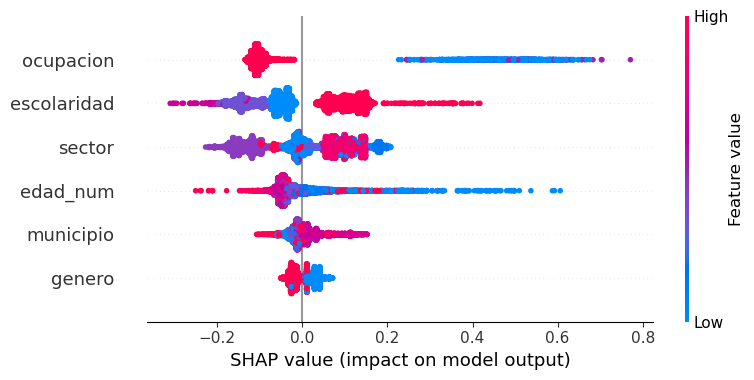

In [977]:
shap.summary_plot(shap_values_1, X_transformed)

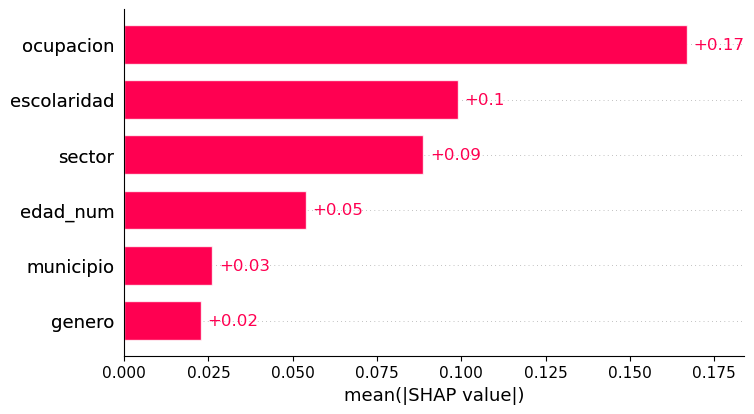

In [111]:
shap.plots.bar(exp)

## Load OD survey

In [885]:
model['preprocessor'].feature_names_in_

array(['genero', 'ocupacion', 'edad_num', 'edad_cat', 'sector',
       'escolaridad', 'municipio'], dtype=object)

In [886]:
X

,genero,ocupacion,edad_num,edad_cat,sector,escolaridad,municipio
0,F,independiente,28,"[25, 50)",Servicios,Primaria o Secundaria,apodaca
1,H,independiente,32,"[25, 50)",Construcción,Primaria o Secundaria,apodaca
2,F,trabajador,25,"[25, 50)",Industria manufacturera,Carrera técnica o preparatoria,apodaca
3,F,trabajador,33,"[25, 50)",Industria manufacturera,Carrera técnica o preparatoria,apodaca
4,F,trabajador,52,"[50, 60)",Industria manufacturera,Carrera técnica o preparatoria,apodaca
...,...,...,...,...,...,...,...
5793,H,trabajador,64,"[60, 65)",Agricultura y ganadería,Primaria o Secundaria,cadereyta
5794,F,trabajador,56,"[50, 60)",Servicios,Primaria o Secundaria,cadereyta
5795,H,trabajador,56,"[50, 60)",Servicios,Primaria o Secundaria,cadereyta
5796,H,trabajador,50,"[50, 60)",Construcción,Primaria o Secundaria,cadereyta


In [134]:
od = pd.read_csv('datos_limpios_tiempos.csv', low_memory=False)
od_clean = pd.read_csv('od_previ_modelo.csv')
od_final = pd.merge(od[['H-P-V', 'Edad', 'FE']], od_clean, on='H-P-V', how='right').rename(columns={'Edad': 'edad_num', 'edad': 'edad_cat'})[list(enoe.columns.drop('informal')) + ['FE']]
od_final

,genero,ocupacion,edad_num,edad_cat,sector,escolaridad,municipio,FE
0,H,trabajador,43,25-49,Comercio,Primaria o Secundaria,monterrey,999.649138
1,H,trabajador,41,25-49,Servicios,Primaria o Secundaria,santa_catarina,93.466828
2,F,trabajador,26,25-49,Servicios,Carrera técnica o preparatoria,santiago,28.734648
3,H,trabajador,20,18-24,Industria manufacturera,Primaria o Secundaria,santiago,23.945540
4,F,trabajador,42,25-49,Servicios,Primaria o Secundaria,santiago,23.945540
...,...,...,...,...,...,...,...,...
20760,F,otro,23,18-24,Servicios,Carrera técnica o preparatoria,garcia,58.917199
20761,H,trabajador,22,18-24,Industria manufacturera,Carrera técnica o preparatoria,salinas,42.284542
20762,H,trabajador,60,60-64,Construcción,Carrera técnica o preparatoria,san_nicolas,154.518136
20763,F,trabajador,45,25-49,Servicios,Primaria o Secundaria,garcia,39.581286


In [666]:
informal_od = model.predict(od_final)
informal_proba = model.predict_proba(od_final)

print(f'Proportion of informal trips in ENOE: {enoe.informal.sum()/enoe.shape[0]:0.4f}')
print(f'Proportion of estimated informal trips in OD (no EF): {informal_od.sum()/od_final.shape[0]:0.4f}')
print(f'Expected value informal trips in OD (no EF): {informal_proba[:, 1].sum()/od_final.shape[0]:0.4f}')
print(f'Proportion of estimated informal trips in OD (with EF): {(od_final.FE.values * informal_od).sum()/od_final.FE.sum():0.4f}')
print(f'Expected value informal trips in OD (with EF): {(od_final.FE.values * informal_proba[:, 1]).sum()/od_final.FE.sum():0.4f}')

Proportion of informal trips in ENOE: 0.3758
Proportion of estimated informal trips in OD (no EF): 0.2905
Expected value informal trips in OD (no EF): 0.3734
Proportion of estimated informal trips in OD (with EF): 0.2897
Expected value informal trips in OD (with EF): 0.3697


In [860]:
# Proportion by sector
od_pred = od_final.assign(informal=informal_od, informal_proba=informal_proba[:, 1])

In [861]:
# Fraction of informal distributed by sector
inf_by_sect = pd.concat(
    [
        (od_pred.groupby('sector').informal.sum()/od_pred.informal.sum()*100).rename('OD'),
        (od_pred.groupby('sector').informal_proba.sum()/od_pred.informal_proba.sum()*100).rename('OD Expected'),
        (enoe.groupby('sector').informal.sum()/enoe.informal.sum()*100).rename('ENOE')
    ],
    axis=1
)
inf_by_sect

,OD,OD Expected,ENOE
sector,,,
Agricultura y ganadería,0.663020,0.697493,5.644791
Comercio,11.138737,14.885248,22.074346
Construcción,12.647108,8.705390,13.171179
Gobierno,2.353721,3.392276,1.652134
Industria manufacturera,5.685397,8.633997,7.526388
Minería,0.066302,0.078274,0.000000
Otro,18.746892,13.949131,0.734282
Servicios,46.560583,47.433612,43.093162
Transporte y comunicaciones,2.138240,2.224579,6.103717


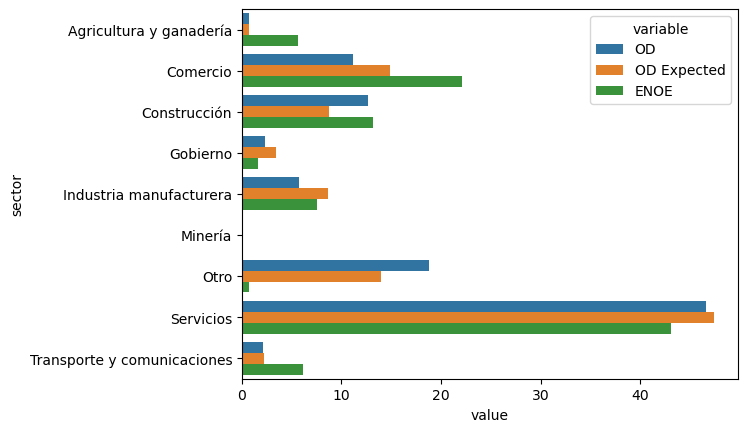

In [862]:
sns.barplot(inf_by_sect.reset_index().melt(id_vars=['sector']), y='sector', x='value', hue='variable');

In [733]:
# Fraction of informal within each sector
inf_within_sect = pd.concat(
    [
        (od_pred.groupby('sector').informal.agg(['sum', 'size']).pipe(lambda df: df['sum']/df['size']*100)).rename('OD'),
        (od_pred.groupby('sector').informal_proba.agg(['sum', 'size']).pipe(lambda df: df['sum']/df['size']*100)).rename('OD Expected'),
        (enoe.groupby('sector').informal.agg(['sum', 'size']).pipe(lambda df: df['sum']/df['size']*100)).rename('ENOE')
    ],
    axis=1
)
inf_within_sect

,OD,OD Expected,ENOE
sector,,,
Agricultura y ganadería,33.057851,44.700789,78.343949
Comercio,19.069240,32.755241,46.205572
Construcción,62.953795,55.698851,62.527233
Gobierno,14.242728,26.384973,21.556886
Industria manufacturera,7.627307,14.888454,12.247946
Minería,11.111111,16.860760,0.000000
Otro,100.000000,95.641231,17.977528
Servicios,32.632435,42.731147,43.512512
Transporte y comunicaciones,20.187793,26.996513,34.816754


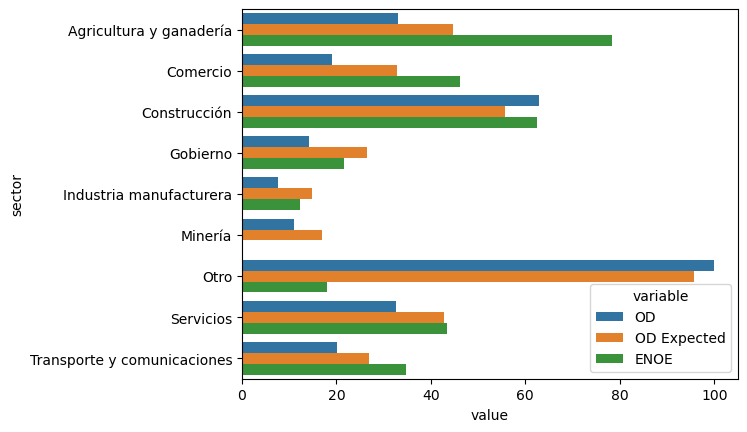

In [734]:
sns.barplot(inf_within_sect.reset_index().melt(id_vars=['sector']), y='sector', x='value', hue='variable');

## Second model, using GB, tune parameters with nested cross validation

In [129]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import cross_validate, GridSearchCV, RepeatedStratifiedKFold

In [130]:
enoe_2 = enoe.query('sector.isin(["Comercio", "Construcción"])')
y2 = enoe_2['sector'].values
X2 = enoe_2.drop(columns=['informal', 'sector'])

In [131]:
model_2 = Pipeline([
            (
                'preprocessor',
                ColumnTransformer([
                    (
                        "od_encoder",
                        OrdinalEncoder(
                            handle_unknown='use_encoded_value',
                            unknown_value=-1
                        ),
                        ['genero', 'escolaridad', 'municipio']
                    ),
                    ('passthrough', 'passthrough', ['edad_num'])
                ])
            ),
            (
                'classifier',
                HistGradientBoostingClassifier(
                    max_iter=1000,
                    early_stopping=True,
                    random_state=0
                )
            )
        ])

param_grid = {
    'classifier__learning_rate': np.geomspace(0.01, 1, 10),
    'classifier__max_leaf_nodes': [5, 7, 10, 25, 50, 65, 85, 100, 250, 500],
}

In [810]:
%%time
cv_inner = RepeatedStratifiedKFold(
        n_splits=10, n_repeats=10, random_state=42
    )
cv_outer = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

search = GridSearchCV(model_2, param_grid, scoring='balanced_accuracy', cv=cv_inner, n_jobs=50, verbose=1)
cv_results = cross_validate(search, X2, y2, scoring=['balanced_accuracy', 'accuracy'], cv=cv_outer, return_estimator=True, verbose=1)

Fitting 100 folds for each of 100 candidates, totalling 10000 fits
Fitting 100 folds for each of 100 candidates, totalling 10000 fits
Fitting 100 folds for each of 100 candidates, totalling 10000 fits
Fitting 100 folds for each of 100 candidates, totalling 10000 fits
Fitting 100 folds for each of 100 candidates, totalling 10000 fits
Fitting 100 folds for each of 100 candidates, totalling 10000 fits
Fitting 100 folds for each of 100 candidates, totalling 10000 fits
Fitting 100 folds for each of 100 candidates, totalling 10000 fits
Fitting 100 folds for each of 100 candidates, totalling 10000 fits
Fitting 100 folds for each of 100 candidates, totalling 10000 fits
CPU times: user 3min 16s, sys: 7.65 s, total: 3min 24s
Wall time: 5min 33s


In [812]:
cv_results = pd.DataFrame(cv_results)
cv_results

,fit_time,score_time,estimator,test_balanced_accuracy,test_accuracy
0,38.348735,0.007077,GridSearchCV(cv=RepeatedStratifiedKFold(n_repe...,0.669523,0.726667
1,34.955553,0.005122,GridSearchCV(cv=RepeatedStratifiedKFold(n_repe...,0.741848,0.793333
2,32.328532,0.007350,GridSearchCV(cv=RepeatedStratifiedKFold(n_repe...,0.702132,0.746667
3,31.955680,0.004791,GridSearchCV(cv=RepeatedStratifiedKFold(n_repe...,0.735786,0.793333
4,33.398210,0.005300,GridSearchCV(cv=RepeatedStratifiedKFold(n_repe...,0.745610,0.773333
5,31.831489,0.005132,GridSearchCV(cv=RepeatedStratifiedKFold(n_repe...,0.732232,0.780000
6,30.952864,0.007015,GridSearchCV(cv=RepeatedStratifiedKFold(n_repe...,0.650293,0.700000
7,30.810578,0.006265,GridSearchCV(cv=RepeatedStratifiedKFold(n_repe...,0.730978,0.786667
8,33.293121,0.011837,GridSearchCV(cv=RepeatedStratifiedKFold(n_repe...,0.661162,0.706667
9,35.121068,0.005749,GridSearchCV(cv=RepeatedStratifiedKFold(n_repe...,0.701587,0.733333


In [814]:
cv_results.agg({'test_balanced_accuracy': ['mean', 'std'], 'test_accuracy': ['mean', 'std']})

,test_balanced_accuracy,test_accuracy
mean,0.707115,0.754000
std,0.035776,0.035894


In [829]:
pd.DataFrame([estimator.best_params_ for estimator in cv_results.estimator])

,classifier__learning_rate,classifier__max_leaf_nodes
0,0.129155,5
1,0.215443,7
2,0.046416,5
3,0.359381,5
4,0.129155,5
5,0.215443,5
6,0.027826,7
7,0.046416,5
8,0.016681,5
9,0.129155,7


In [139]:
model_2.set_params(classifier__learning_rate=0.1, classifier__max_leaf_nodes=5)
model_2.fit(X2, y2)
model_2.score(X2, y2)

0.78

In [135]:
od_final_2 = od_final.query("sector == 'Otro'")
od_final_2

,genero,ocupacion,edad_num,edad_cat,sector,escolaridad,municipio,FE
31,H,otro,14,12-14,Otro,Carrera técnica o preparatoria,santiago,23.945540
34,F,otro,24,18-24,Otro,Primaria o Secundaria,santiago,36.876132
125,F,otro,32,25-49,Otro,Primaria o Secundaria,santiago,23.945540
133,F,otro,55,50-59,Otro,Primaria o Secundaria,santiago,28.734648
137,F,otro,65,65-130,Otro,Primaria o Secundaria,santiago,28.734648
...,...,...,...,...,...,...,...,...
20723,F,otro,42,25-49,Otro,Carrera técnica o preparatoria,san_pedro,109.531927
20725,H,otro,62,60-64,Otro,Carrera técnica o preparatoria,san_pedro,109.531927
20726,H,otro,79,65-130,Otro,Carrera técnica o preparatoria,san_pedro,109.531927
20727,F,otro,68,65-130,Otro,Carrera técnica o preparatoria,san_pedro,109.531927


In [864]:
od_pred = od_pred.assign(sector_2=pd.Series(model_2.predict(od_final_2), index=od_final_2.index).reindex(od_pred.index).pipe(lambda s: s.mask(s.isna(), od_pred.sector)))

In [866]:
od_pred.to_csv('od_pred.csv', index=False)

In [144]:
X_transformed_2

,genero,escolaridad,municipio,edad_num
0,1.0,3.0,0.0,32.0
1,0.0,3.0,0.0,60.0
2,1.0,3.0,0.0,54.0
3,1.0,0.0,0.0,32.0
4,1.0,1.0,0.0,30.0
...,...,...,...,...
1495,0.0,3.0,1.0,25.0
1496,1.0,0.0,1.0,48.0
1497,1.0,0.0,1.0,23.0
1498,1.0,3.0,1.0,54.0


In [143]:
X_transformed_2 = model_2['preprocessor'].transform(X2)
X_transformed_2 = pd.DataFrame(X_transformed_2, columns=[name.split('__')[1] for name in model_2['preprocessor'].get_feature_names_out()])
explainer_2 = shap.TreeExplainer(model_2['classifier'], data=X_transformed_2, model_output='probability')
#shap_values_2 = explainer_2.shap_values(X_transformed_2, y2)
#exp_2 = explainer_2(X_transformed_2, y2)
#shap.plots.bar(exp_2)

In [149]:
exp2 = explainer_2(X_transformed_2)

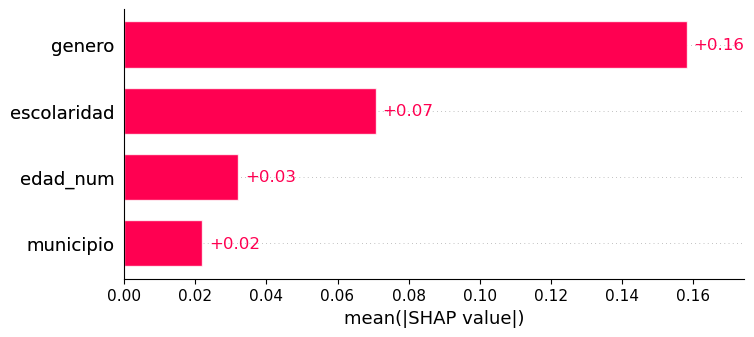

In [151]:
shap.plots.bar(exp2)